In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mylibrary.nnlib as tnn

In [53]:
class KLipschitzNet(tnn.Layer):
    
    def __init__(self, layer_dims, optimizer, output_activation=tnn.Linear(), K=1):
        layer_list = []
        self.K = K
        for i in range(len(layer_dims)-1):
            if i+2 == len(layer_dims):
                actv = output_activation
            else:
                actv = tnn.Relu()
            layer = tnn.NonLinearLayer(layer_dims[i], layer_dims[i+1], activation=actv, optimizer=optimizer)
            layer_list.append(layer)

        self._net = tnn.AutoForm()
        self._net.layerList = layer_list
        
        self.preprocess()
        
    def preprocess(self):
        ## for all hidden layers
        for layer in self._net.layerList[:-1]:
            norm = np.linalg.norm(layer.weights,2,0, keepdims=True)
            print(layer.weights)
            print(norm)
            layer.weights /= norm
        ## if the problem is regression, restirct the last layer for K-Lipschitz
        ## output layer
        layer = self._net.layerList[-1]
        norm = np.linalg.norm(layer.weights,2,0, keepdims=True)
        ## renormalize if the norm is greater than 1.
        re_norm = np.maximum(norm, 1)
        layer.weights /= re_norm
        return
        
    def forward(self,inputs):
        out = self._net.forward(inputs)
        return out
    
    def backward(self, del_output):
        dx = self._net.backward(del_output)
        return dx
    
    def update(self):  
        self._net.update()
        self.preprocess()

### 1D Regression Dataset

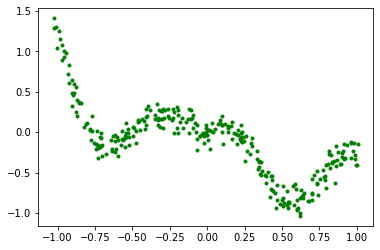

In [54]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
y = -y

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [55]:
optim = tnn.Adam(0.01)
net = KLipschitzNet([1,15,1], optim)

[[-0.62753479  1.01054756  0.93145855  0.27704164  0.64795055 -2.68462163
   1.0091648   0.28850008 -2.43934865 -0.58132935 -0.07985183  1.16493972
  -0.45537917 -0.41397957  0.10529298]]
[[0.62753479 1.01054756 0.93145855 0.27704164 0.64795055 2.68462163
  1.0091648  0.28850008 2.43934865 0.58132935 0.07985183 1.16493972
  0.45537917 0.41397957 0.10529298]]


In [46]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    dx = net.backward(dy)
    net.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5558580413796449


100 Error =  0.0808711250707865


200 Error =  0.06232161563071642


300 Error =  0.059013533096698295


400 Error =  0.057001265917556776


500 Error =  0.05546973355461418


600 Error =  0.05508420605255775


700 Error =  0.054984528737415606


800 Error =  0.05491108630487332


900 Error =  0.054837654801298076


1000 Error =  0.054757600569816725


1100 Error =  0.05468391682098094


1200 Error =  0.05460917296538075


1300 Error =  0.0545295303524403


1400 Error =  0.054368984811672655


1500 Error =  0.05299603300914641


1600 Error =  0.05260049538579812


1700 Error =  0.05253002920084624


1800 Error =  0.05246192909033593


1900 Error =  0.05239530908965279


2000 Error =  0.05233157727164938


2100 Error =  0.05227093425553054


2200 Error =  0.05221411877404055


2300 Error =  0.05214906393184727


2400 Error =  0.05209900683365959


2500 Error =  0.05204796499918851


2600 Error =  0.05199377879230455


2700 Error =  0.05193341680918136


2

TclError: invalid command name "pyimage105"

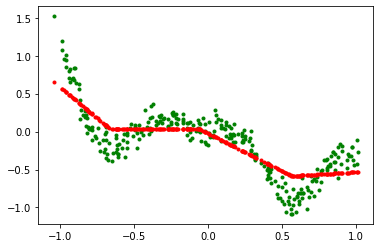

In [47]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

In [ ]:
## This does not allow each piece to be K-Liptsiz.. 
## if one region(neuron) has high weight, other will have low.. 
## we need all pieces to have freedom to have K-slope 
## (it can be easy for Soft decision tree due to independence)

### 2D Regression Dataset

In [48]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

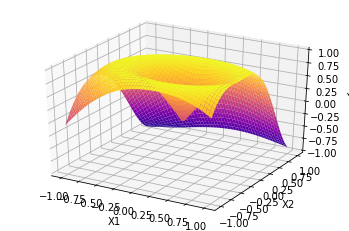

In [49]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
# Y = -Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [50]:
optim = tnn.Adam(0.01)
net = KLipschitzNet([2, 15, 1,], optim)

In [51]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = -net.forward(xx)
    dy = yout - yy
    dx = net.backward(-dy)
    net.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.9976461249572388


100 Error =  0.05686216128651209


200 Error =  0.03247234785925051


300 Error =  0.029387434570457997


400 Error =  0.028456038316866047


500 Error =  0.027512152573444384


600 Error =  0.025944601428441343


700 Error =  0.025009911178941663


800 Error =  0.02477024847597263


900 Error =  0.02454140563979208


1000 Error =  0.02457641264691663


1100 Error =  0.02457723863603161


1200 Error =  0.02455610478310361


1300 Error =  0.024540121005419996


TclError: invalid command name "."

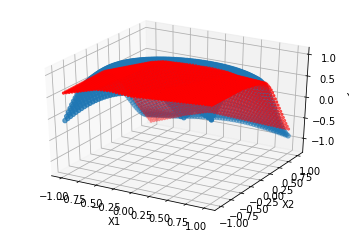

In [52]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## classification

In [45]:
from sklearn.datasets import make_moons

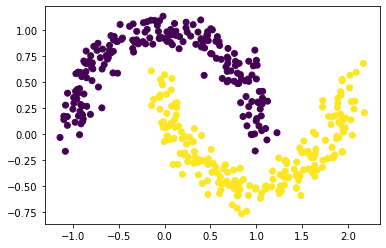

In [46]:
X, y = make_moons(n_samples=400, noise=0.1)
x1 = X[:,0]
x2 = X[:,1]

xx = X
yy = y.astype(float).reshape(-1,1)
%matplotlib inline
plt.scatter(x1, x2, c=y)

In [48]:
optim = tnn.Adam(0.01)
net = ResidualConvex(2, 15, 1, optim)

In [50]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = tnn.SigmoidCrossEntropyBinary.del_loss(yout, yy)
#     dy = tnn.CrossEntropyBinary.del_loss(yout, yy)
    dx = net.backward(dy)
    net.update()
    
    if epoch%100 == 0:
        
        error = tnn.SigmoidCrossEntropyBinary.loss(yout, yy)
#         error = tnn.CrossEntropyBinary.loss(yout, yy)

        print(epoch, 'Error = ', error)
        
        out = (yout>0.5).astype(float)
        
        ax.clear()
        ax.scatter(x1, x2, c=y)
        ax.scatter(x1, x2, c=out.reshape(-1), marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.8381934373155022


100 Error =  0.5800282193231858


200 Error =  0.5788745362785925


300 Error =  0.5738094094436488


400 Error =  0.5683002559710725


500 Error =  0.5674632078503331


600 Error =  0.5673063801356534


700 Error =  0.5672688168872608


800 Error =  0.5671659101463926


900 Error =  0.5671548192393963


1000 Error =  0.5671296258077148


1100 Error =  0.5671037207701667


1200 Error =  0.567119888902681


1300 Error =  0.5670644482595162


1400 Error =  0.5669712184493941


1500 Error =  0.5669029133586964


1600 Error =  0.5670730294560875


1700 Error =  0.567016952231654


1800 Error =  0.5666782823562371


1900 Error =  0.5666668163225704


2000 Error =  0.5667117344654286


2100 Error =  0.5666953384828479


2200 Error =  0.5667532872257961


2300 Error =  0.5666592871649594


2400 Error =  0.5667860514040277


2500 Error =  0.5666523129650937


2600 Error =  0.5668953099560536


2700 Error =  0.5667532219159648


2800 Error =  0.5666163343830468



TclError: invalid command name "pyimage146"

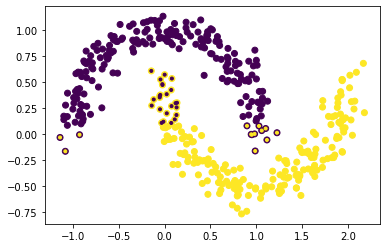

In [51]:
%matplotlib inline
plt.scatter(x1, x2, c=y)
plt.scatter(x1, x2, c=out.reshape(-1), marker='.')